In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os
#------------------------------------------
# the check function applies gaussian smoothing and downsamples the image by 2 on both sides
'''
inputs img--- image
       a,b ----- shape of the image
       sig ---- standard deviation for gaussian smoothing
'''
def check(img,a,b,k,sig):
    a = (a+1)//2 if a%2==1 else a//2
    b = (b+1)//2 if b%2==1 else b//2
    nxt = cv2.GaussianBlur(img,(k,k),sig)
    nxt = cv2.resize(nxt,(b,a))
    return nxt,a,b
#--------------------------------------------
'''
    Gaussian_Pyramid
    img = image, n = number of levels
    first level is considered as level 0
'''
def Gaussian_Pyramid(img,n,k=5,sig=1):
    pyramids = {}
    a,b = img.shape
    for level in range(n):
        pyramids[level] = cv2.GaussianBlur(img,(k,k),sig)
        a = a//2; b = b//2
        img = cv2.resize(pyramids[level],(b,a))
    return pyramids
'''
    Laplacian_Pyramid
    img = image, n = number of levels
    first level is considered as level 0
'''

def Laplacian_Pyramid(img,n,k=5,sig = 1):
    pyramids = {}
    a,b = img.shape    
    prev = cv2.GaussianBlur(img,(k,k),sig)
    for level in range(n):
        f1 = b; f2 = a
        nxt,a,b = check(prev,a,b,k,sig)
        # print((f1,f2))
        # print(prev.shape,nxt.shape)
        lap = cv2.subtract(prev , cv2.resize(nxt,(f1,f2)))
        pyramids[level] = lap
        prev = nxt
    return pyramids

#--------------------------------------------
'''
code for the gradient of I
'''

def gradient_I(img):
    Ix = cv2.Sobel(img,-1,0,1) #sobel horizontal 
    Iy = cv2.Sobel(img,-1,1,0) # sobel vertical
    return Ix,Iy
#---------------------------------------------
#if the data is a video, the below function separates the frames of the video and saves it in the required location
'''
inputs video_path-----path to the video
       dest_loc ----- destination path to store the frames
'''
def sep_frames_vid(video_path,dest_loc):
    cap= cv2.VideoCapture(video_path)
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        cv2.imwrite(dest_loc+'/'+'%06d.jpg'%i,frame)
        i+=1
 
    cap.release()
    cv2.destroyAllWindows()

#-----------------------------------------------------
'''
absolute difference between 2 images
'''
def img_difference(img1,img2):
    diff = img1-img2
    diff = abs(diff)
    diff = np.int32(diff)
    return diff
#-----------------------------------------------------
#code for image modification
'''
inputs  ref_img --- reference image I(t)
        img_unmod --- unmodified image I(t-1)
        U_img ---- (u,v) values matrix 
'''

def img_modification(ref_img,img_unmod,U_img):
    img_mod = np.zeros(img_unmod.shape)             #initializing the image modified
    x_max,y_max = img_unmod.shape
    for i in range(x_max):                          #for every (i,j) in the unmodified image
        for j in range(y_max):
            u1,v1 = np.int32(np.floor(U_img[i,j,:]))    #flooring (u,v)
            u2,v2 = np.int32(np.ceil(U_img[i,j,:]))     #ceiling (u,v)
            if (np.array([i-u1,i-u2])<x_max).all() and (np.array([i-u1,i-u2])>=0).all() and (np.array([j-v1,j-v2])<y_max).all() and (np.array([j-v1,j-v2])>=0).all():
                if  abs(ref_img[i,j]-img_unmod[i-u1,j-v1])<abs(ref_img[i,j]-img_unmod[i-u2,j-v2]): #comparing how close is the pixel intensity to that of the reference image at the same location
                    img_mod[i,j] = img_unmod[i-u1,j-v1]
                else:
                    img_mod[i,j] = img_unmod[i-u2,j-v2]
    return img_mod
#-----------------------------------------------------
# main function for the general flow
'''
img1 = I(t-1)
img2 = I(t)
iterations --- iter = 10 (default)
take a look at Pg 10 equation no. 22 for eq of the form L*delta_u = -R
NOTE: the function is computationally intensive. Therefore make sure to images are of moderate size.
'''
def general_flow(img1,img2,U_prev,iter=10):
    Ix,Iy = gradient_I(img2)                        #gradient of the reference image
    m_max,n_max = img2.shape
    #U_prev = np.zeros((m_max,n_max,2))              #initializing all the (u,v) to be 0
    img1_mod = img1.copy()                           #initializing modified image (img1) 
    for it in range(iter):
        delta_I = img2-img1_mod                 # difference between the images
        for i in range(1,m_max-1):
            for j in range(1,n_max-1):
                L = 0                               #initializing LHS and RHS of the equation 
                R = 0
                for p in range(i-1,i+2):           #considering the 3x3 window to get better results
                    for q in range(j-1,j+2):
                        grad_I = np.array([[Ix[p,q]],[Iy[p,q]]])    #picking the grad_I values at (p,q) location
                        L1 = np.matmul(grad_I,grad_I.T)             #calculating LHS and RHS values and summing them up 
                        L = L + L1
                        R1 = grad_I*delta_I[p,q]
                        R = R + R1
                R = -1*R
                delta_u = np.matmul(np.linalg.pinv(L),R)            #calculating delta_u 
                U_prev[i,j,0] = U_prev[i,j,0] + delta_u[0]          #adding the incremental error to the U_prev
                U_prev[i,j,1] = U_prev[i,j,1] + delta_u[1]
        img1_mod = img_modification(img2,img1,U_prev)               #modifying the image based on New U_prev
    
    return U_prev,img1_mod              #returning U_prev and modified image


def hier_general(img1,img2,no_of_levels,pyramid = 'Gaussian' ,iter_per_level = 4, k=3,sig = 1): 
    if pyramid == 'Gaussian':
        py_img1 = Gaussian_Pyramid(img1,no_of_levels,k,sig)                 #gaussian pyramid
        py_img2 = Gaussian_Pyramid(img2,no_of_levels,k,sig)
    elif pyramid == 'Laplacian':
        py_img1 = Laplacian_Pyramid(img1,no_of_levels,k,sig)                #Laplacian pyramid
        py_img2 = Laplacian_Pyramid(img2,no_of_levels,k,sig)    
    a,b = img1.shape
    U_prev = np.zeros((a,b,2))                                              #U_mat initialization
    for i in range(no_of_levels-1,-1,-1):                                   # i ---level number
        a,b = py_img1[i].shape                                              
        U_prev = cv2.resize(U_prev,(b,a))                                   # resizing U_prev to move it to next level
        U_prev ,img1_mod =general_flow(py_img1[i],py_img2[i],U_prev,iter=iter_per_level) #planar flow per level
        print(i)                                                                #printing the level number                                              
    return U_prev,img1_mod                                                      #returning U_prev and modified image


RUN THE CODE FROM HERE

In [ ]:
img1 = cv2.imread('/content/drive/Shared drives/CV_Project/Dataset/general_flow /2/000045_10.png') #I(t-1)
img2 = cv2.imread('/content/drive/Shared drives/CV_Project/Dataset/general_flow /2/000045_11.png') #I(t)
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)                        #converting both the images to gray 
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
U_prev, img1_mod = hier_general(img1,img2,3,pyramid = 'Gaussian' ,iter_per_level = 4, k=3,sig = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in ubyte_scalars


True

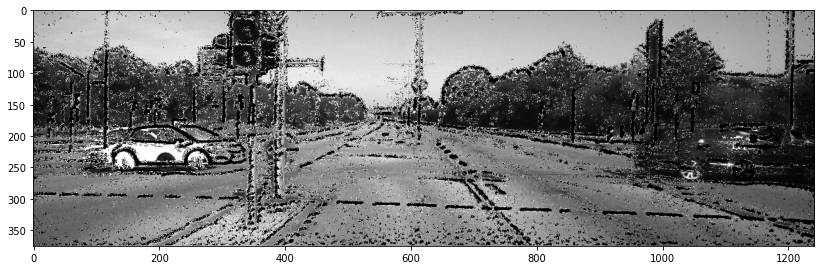

In [ ]:
out = img_modification(img2,img1,U_prev)                        #getting the output image through image modification
plt.figure(figsize=(14,20))
plt.imshow(out,cmap='gray')
cv2.imwrite('/content/drive/Shared drives/CV_Project/Dataset/general_flow /2_results/img_modified.png',out)

True

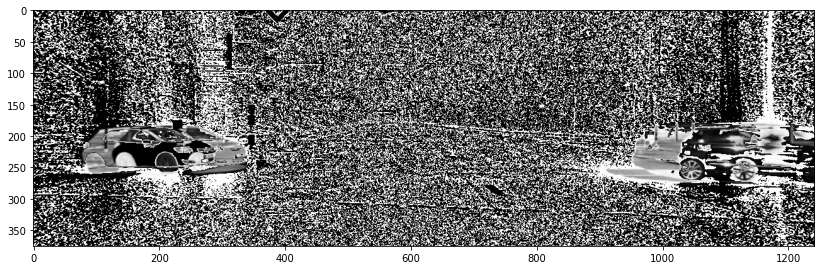

In [ ]:
# raw absolute image difference
diff = img_difference(img1,img2)
plt.figure(figsize=(14,20))
plt.imshow(diff,cmap='gray')
cv2.imwrite('/content/drive/Shared drives/CV_Project/Dataset/general_flow /2_results/raw_diff.png',diff)

True

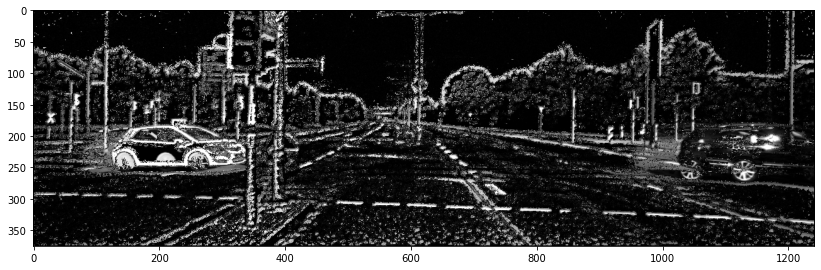

In [ ]:
#compensated absolute image difference
diff = img_difference(out,img2)
plt.figure(figsize=(14,20))
plt.imshow(diff,cmap='gray')
cv2.imwrite('/content/drive/Shared drives/CV_Project/Dataset/general_flow /2_results/comp_diff.png',diff)